In [ ]:
! pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images[..., tf.newaxis] / 255.0
test_images = test_images[..., tf.newaxis] / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Build a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

In [4]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Build the model by running it on a sample input
model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [5]:
# Train the model
model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))


Epoch 1/5
1875/1875 [==============================] - 69s 36ms/step - loss: 0.1415 - accuracy: 0.9566 - val_loss: 0.0481 - val_accuracy: 0.9837
Epoch 2/5
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0464 - accuracy: 0.9862 - val_loss: 0.0407 - val_accuracy: 0.9865
Epoch 3/5
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0329 - accuracy: 0.9898 - val_loss: 0.0401 - val_accuracy: 0.9869
Epoch 4/5
1875/1875 [==============================] - 55s 30ms/step - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.0347 - val_accuracy: 0.9886
Epoch 5/5
1875/1875 [==============================] - 55s 30ms/step - loss: 0.0196 - accuracy: 0.9938 - val_loss: 0.0298 - val_accuracy: 0.9911


In [ ]:
# Function to generate SCORE-CAM heatmaps
def generate_score_cam(model, image, class_index, layer_name='conv3'):
    # Create a sub-model that maps the input image to the feature map
    cam_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Get the feature maps of the image
    feature_maps = cam_model.predict(image[np.newaxis, ...])

    # Get the prediction of the class of interest
    with tf.GradientTape() as tape:
        tape.watch(image)
        logits = model(image[np.newaxis, ...])
        score = logits[0, class_index]

    # Apply global average pooling to the feature maps
    weights = tf.reduce_mean(feature_maps, axis=(0, 1, 2))

    # Compute the weighted sum of the feature maps
    weighted_feature_maps = tf.reduce_sum(tf.multiply(feature_maps, weights), axis=-1)[0]

    # Normalize the weighted feature maps
    heatmap = tf.maximum(weighted_feature_maps, 0) / tf.reduce_max(weighted_feature_maps)

    return heatmap.numpy()

In [ ]:
# Visualize the SCORE-CAM for a test image
test_image = test_images[0]
class_index = np.argmax(model.predict(test_image[np.newaxis, ...]))

heatmap = generate_score_cam(model, test_image, class_index)

# Plot the original image and the heatmap
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_image[..., 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[..., 0], cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title('SCORE-CAM Heatmap')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


ValueError: The layer sequential_1 has never been called and thus has no defined input.

In [ ]:
def run_cam(model, image, target, verbose=False):
    # Extract convolutional layers
    cnn_layers = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.MaxPooling2D) or isinstance(layer, tf.keras.layers.AvgPooling2D):
            cnn_layers.append(layer)

    x = image[tf.newaxis, ...]  # Add batch dimension
    sx, sy = image.shape[:2]

    # 1. Pass input image only through the convolutional layers
    for layer in cnn_layers:
        x = layer(x)

    # 2. Interpolate back to the original size
    x = tf.image.resize(x, (sx, sy), method='bilinear')

    if verbose:
        print("Calculating image masks...")

    # 3. Normalize each mask
    # 4. Project normalized masks to original image
    _, _, _, k = x.shape
    masked_images = []
    for i in range(k):
        feature_map = x[0, :, :, i]
        max_val = tf.reduce_max(feature_map)
        min_val = tf.reduce_min(feature_map)
        normalized_map = (feature_map - min_val) / (max_val - min_val + 1e-4)
        masked_image = image * normalized_map[..., tf.newaxis]
        masked_images.append(masked_image)

    if verbose:
        print("Passing masked images through the network...")

    # 5. Pass each mask through the original network and calculate score
    weight_scores = []
    for m_img in masked_images:
        m_img = m_img[tf.newaxis, ...]
        logits = model(m_img)
        if tf.keras.layers.Softmax() in model.layers:
            out = tf.nn.softmax(logits, axis=1).numpy()
        else:
            out = np.exp(logits.numpy())

        weight_scores.append(out[0][target])

    if verbose:
        print("Constructing image with the CAM...")

    # 6. Construct cam-points of interest
    output_img = tf.zeros_like(image)
    for ws, mask in zip(weight_scores, masked_images):
        if not np.isnan(ws):
            output_img += tf.nn.relu(mask * ws)

    if verbose:
        return masked_images, weight_scores, output_img
    else:
        return output_img

1/1 [==============================] - 0s 109ms/step
Calculating image masks...
Passing masked images through the network...
Constructing image with the CAM...


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

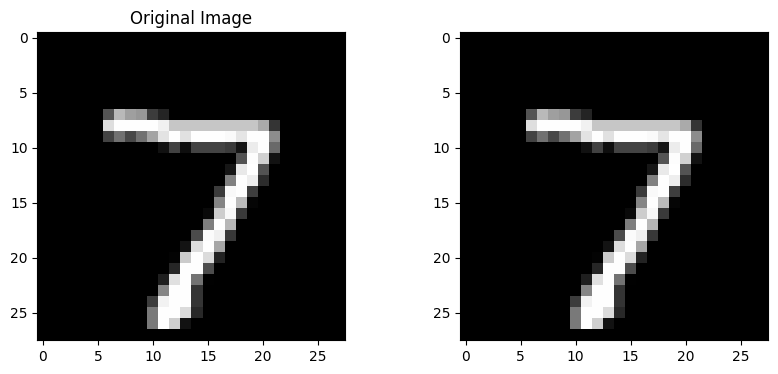

In [6]:
def run_cam(model, image, target, verbose=False):
    # Extract convolutional layers
    cnn_layers = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.MaxPooling2D) or isinstance(layer, tf.keras.layers.AveragePooling2D):
            cnn_layers.append(layer)

    x = image[tf.newaxis, ...]  # Add batch dimension
    sx, sy = image.shape[:2]

    # 1. Pass input image only through the convolutional layers
    for layer in cnn_layers:
        x = layer(x)

    # 2. Interpolate back to the original size
    x = tf.image.resize(x, (sx, sy), method='bilinear')

    if verbose:
        print("Calculating image masks...")

    # 3. Normalize each mask
    # 4. Project normalized masks to original image
    _, _, _, k = x.shape
    masked_images = []
    for i in range(k):
        feature_map = x[0, :, :, i]
        max_val = tf.reduce_max(feature_map)
        min_val = tf.reduce_min(feature_map)
        normalized_map = (feature_map - min_val) / (max_val - min_val + 1e-4)
        masked_image = image * normalized_map[..., tf.newaxis]
        masked_images.append(masked_image)

    if verbose:
        print("Passing masked images through the network...")

    # 5. Pass each mask through the original network and calculate score
    weight_scores = []
    for m_img in masked_images:
        m_img = m_img[tf.newaxis, ...]
        logits = model(m_img)
        if any(isinstance(layer, tf.keras.layers.Softmax) for layer in model.layers):
            out = tf.nn.softmax(logits, axis=1).numpy()
        else:
            out = np.exp(logits.numpy())

        weight_scores.append(out[0][target])

    if verbose:
        print("Constructing image with the CAM...")

    # 6. Construct cam-points of interest
    output_img = tf.zeros_like(image, dtype=tf.float32)
    for ws, mask in zip(weight_scores, masked_images):
        if not np.isnan(ws):
            output_img += tf.nn.relu(tf.cast(mask * ws, tf.float32))

    if verbose:
        return masked_images, weight_scores, output_img
    else:
        return output_img  # Ensure output_img is returned as tensor

# Test the run_cam function with a sample image
test_image = test_images[0]
class_index = np.argmax(model.predict(test_image[tf.newaxis, ...]))

output_img = run_cam(model, test_image, class_index, verbose=True)

# Plot the original image and the output CAM image
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_image[..., 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[..., 0], cmap='gray')
output_img_squeezed = np.squeeze(output_img, axis=-1)
plt.imshow(output_img_squeezed, cmap='jet', alpha=0.5)
plt.title('SCORE-CAM Output')

plt.show()

1/1 [==============================] - 0s 63ms/step
Calculating image masks...
Passing masked images through the network...
Constructing image with the CAM...


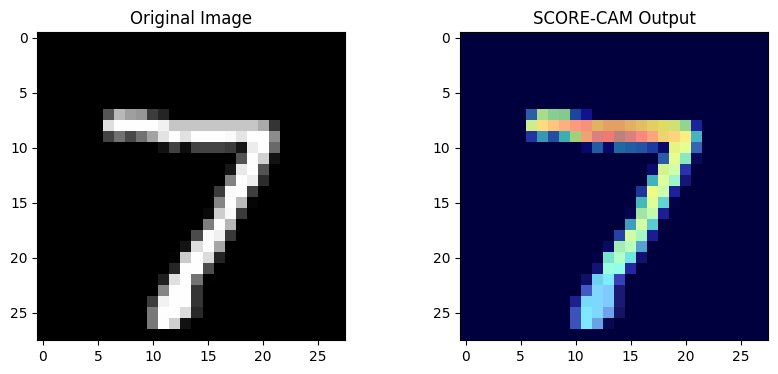

In [7]:
def run_cam(model, image, target, verbose=False):
    # Extract convolutional layers
    cnn_layers = []
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.MaxPooling2D) or isinstance(layer, tf.keras.layers.AveragePooling2D):
            cnn_layers.append(layer)

    x = image[tf.newaxis, ...]  # Add batch dimension
    sx, sy = image.shape[:2]

    # 1. Pass input image only through the convolutional layers
    for layer in cnn_layers:
        x = layer(x)

    # 2. Interpolate back to the original size
    x = tf.image.resize(x, (sx, sy), method='bilinear')

    if verbose:
        print("Calculating image masks...")

    # 3. Normalize each mask
    # 4. Project normalized masks to original image
    _, _, _, k = x.shape
    masked_images = []
    for i in range(k):
        feature_map = x[0, :, :, i]
        max_val = tf.reduce_max(feature_map)
        min_val = tf.reduce_min(feature_map)
        normalized_map = (feature_map - min_val) / (max_val - min_val + 1e-4)
        masked_image = image * normalized_map[..., tf.newaxis]
        masked_images.append(masked_image)

    if verbose:
        print("Passing masked images through the network...")

    # 5. Pass each mask through the original network and calculate score
    weight_scores = []
    for m_img in masked_images:
        m_img = m_img[tf.newaxis, ...]
        logits = model(m_img)
        if any(isinstance(layer, tf.keras.layers.Softmax) for layer in model.layers):
            out = tf.nn.softmax(logits, axis=1).numpy()
        else:
            out = np.exp(logits.numpy())

        weight_scores.append(out[0][target])

    if verbose:
        print("Constructing image with the CAM...")

    # 6. Construct cam-points of interest
    output_img = tf.zeros_like(image, dtype=tf.float32)
    for ws, mask in zip(weight_scores, masked_images):
        if not np.isnan(ws):
            output_img += tf.nn.relu(tf.cast(mask * ws, tf.float32))

    # Return only output_img regardless of verbose
    return output_img  # Ensure output_img is returned as tensor

# Test the run_cam function with a sample image
test_image = test_images[0]
class_index = np.argmax(model.predict(test_image[tf.newaxis, ...]))

output_img = run_cam(model, test_image, class_index, verbose=True)

# Plot the original image and the output CAM image
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_image[..., 0], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(test_image[..., 0], cmap='gray')
# Squeeze the output_img directly, as it is now a single tensor
output_img_squeezed = np.squeeze(output_img.numpy(), axis=-1)  # Convert to NumPy array before squeezing
plt.imshow(output_img_squeezed, cmap='jet', alpha=0.5)
plt.title('SCORE-CAM Output')

plt.show()

In [9]:
! pip install shap
import shap
explainer = shap.DeepExplainer(model, data=train_images[:100])  # Use a subset of training data for faster computation


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [10]:
# Calculate SHAP values for test images
num_test_images = 10  # Number of test images to explain
test_images_sample = test_images[:num_test_images]
shap_values = explainer.shap_values(test_images_sample)


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


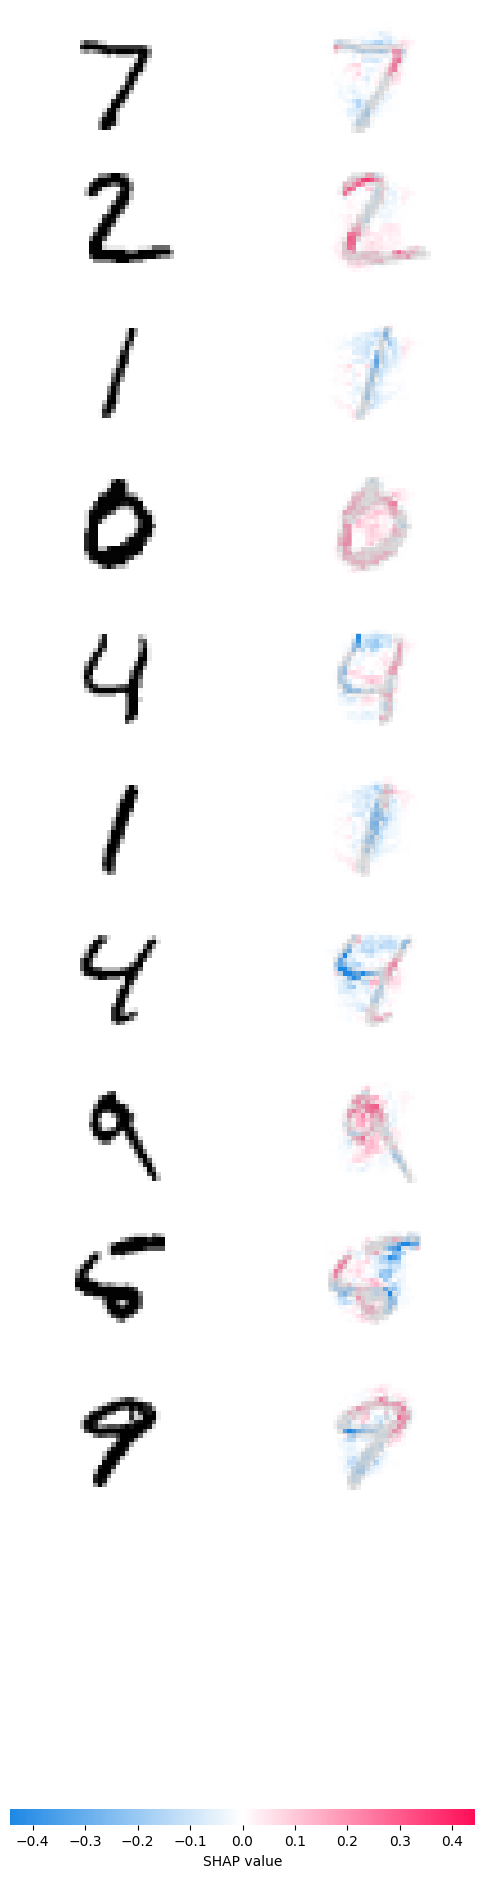

In [11]:
# Visualize SHAP values
shap.image_plot(shap_values, -test_images_sample)
